In [1]:
# demo de-noising using fhmm
# this was attempt 1, all is working but need to streamline so that
# it's simpler to run lots of tests

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [82]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK = 'humpback'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000
nfft = 256

signal_types = [HUMPBACK, BOWHEAD, NOISE]

# type to label
signal_types_labels = {
    HUMPBACK: 0,
    BOWHEAD: 1,
    NOISE: 2
}

# label to type
label_to_type = {
    0: HUMPBACK,
    1: BOWHEAD,
    2: NOISE
}

get_data_dict = {
    HUMPBACK: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_WAV_B,constants.BOWHEAD_LABELS_B, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(constants.BOWHEAD_WAV_B,constants.BOWHEAD_LABELS_B_NOISE, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)

__collected samples__
humpback :  18
bowhead :  21
noise :  33


In [4]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)

In [102]:
cv_index = 0    # select train and test for this iteration
importlib.reload(useful)
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])

# Train

In [154]:
# train hmms
from hmmlearn.hmm import GaussianHMM

hmms = {
    HUMPBACK: GaussianHMM(5),
    BOWHEAD: GaussianHMM(5),
    NOISE: GaussianHMM(4)
}

train.features = []
for sample in train.samples:
    train.features.append(useful.get_log_power_feature(sample, nfft))

for key in hmms:
    cur_hmm = hmms[key]
    feat_indicis = train.sample_labels == signal_types_labels[key]
    hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
    cur_hmm.fit(np.concatenate(hmm_features))

In [155]:
# check / update hmms
importlib.reload(useful)
print(useful.find_similar_states_kl(hmms[BOWHEAD], hmms[NOISE]))

[[ 70.20779449  50.02362222  54.75815836 361.13199571]
 [  4.92428477  12.05144635   6.77030806 161.00060574]
 [ 42.59826694  35.11369634  34.03273559 270.32431352]
 [ 60.07584723  56.95809635  55.26651712 332.23908815]
 [ 55.80528384  59.87770584  48.23219738 328.60853357]]


In [156]:
hmm_bowhead_updated = useful.delete_component(hmms[BOWHEAD], 1)
print(useful.find_similar_states_kl(hmm_bowhead_updated, hmms[NOISE]))
hmms[BOWHEAD] = hmm_bowhead_updated

deleting comp 1
[[ 70.20215713  50.04846746  54.7983766  361.25487792]
 [ 42.58371709  35.08501424  34.05708866 270.25920173]
 [ 60.09273751  57.08536862  55.31095144 332.14881727]
 [ 55.69952806  59.88227909  48.10312731 328.61245481]]


In [158]:
print(useful.find_similar_states_kl(hmms[HUMPBACK], hmms[NOISE]))

[[146.4184041  194.3930679  244.32208751 233.27167589]
 [120.99868683 137.13103293 248.7539437  286.26496874]
 [128.89654563 156.52860501 249.66313531 201.43043901]
 [108.51455561 166.63923381 291.00013191 143.25394664]
 [ 93.57733982 170.87494869 312.18528389  30.1027059 ]]


In [159]:
hmm_humpback_updated = useful.delete_component(hmms[HUMPBACK], 4)
print(useful.find_similar_states_kl(hmm_humpback_updated, hmms[NOISE]))
hmms[HUMPBACK] = hmm_humpback_updated

deleting comp 4
[[146.53268719 194.14260908 244.15636462 233.46443826]
 [120.75522758 137.07941248 248.73666514 286.09578798]
 [128.80921676 156.32533883 250.38934775 201.57465626]
 [108.58287607 166.91997213 290.67203419 143.2593548 ]]


In [160]:
# get accuracy measure then decode combine
import sklearn.metrics
import decode_combine as dc
importlib.reload(dc)
combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])

## Validation

In [172]:
# if validate has added noise or reverb add here

import noisey
import matplotlib.pyplot as plt
importlib.reload(noisey)

signal_avg_db = noisey.get_signal_avg_db(np.concatenate(samples))

def get_noise_for_sample(sig_db, sample, snr_1=15, snr_2=15, snr_3=8):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noise_sample, _ = noisey.generate_gaussian_noise(len(sample), noise_power_1, noise_power_2, noise_power_3)
    return noise_sample

# noise_example = add_noise_to_sample(signal_avg_db, samples[0])
# plt.plot(noise_example)
# plt.plot(samples[0])
# plt.show()
# noisey.get_signal_avg_db(noise_example)
# noisey.get_signal_avg_db(samples[5])
# def add_noise_to_sample(sample):

In [173]:
importlib.reload(useful)
val.features = []
noise_samples = []
noise_features = []
for i in range(len(val.samples)):

    # ---- noise / reverb adjustments ---- START
    noise_sample = get_noise_for_sample(signal_avg_db, val.samples[i])
    noise_samples.append(noise_sample)
    noise_features.append(useful.get_log_power_feature(noise_sample, nfft))
    adjusted_sample = val.samples[i] + noise_sample
    # ---- noise / reverb adjustments ---- END

    feature = useful.get_log_power_feature(adjusted_sample, nfft)
    val.features.append(feature)
val.update_feature_labels()

In [174]:
_, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred)
print(accuracy)

decoding using hmmlearn
{'acc': 0.40463592844545226, 'tpr': 0.2932551319648094, 'fpr': 0.21555555555555556}


In [175]:
# optional create FHMM's

noise_hmm = GaussianHMM(3, covariance_type='full')
noise_hmm.fit(np.concatenate(noise_features))

GaussianHMM(covariance_type='full', n_components=3)

In [176]:
from final.models.fhmm import FactorialHMM

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred_fhmm)
print(accuracy)

decoding using hmmlearn
{'acc': 0.9394563426688632, 'tpr': 0.9404506437768241, 'fpr': 0.06382978723404255}


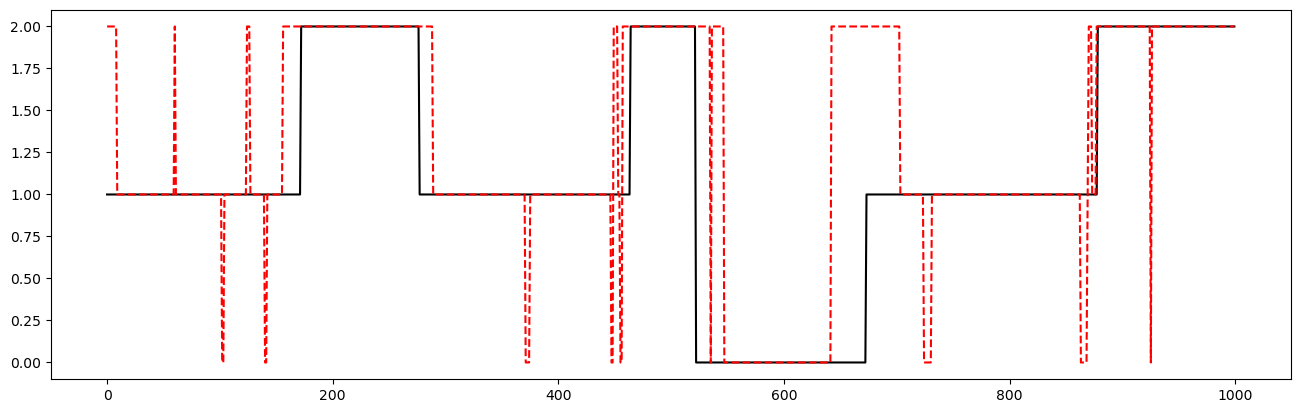

In [177]:
# val subset

val_true_subset = np.concatenate(val.feature_labels)[:1000]
val_pred_subset = val_pred_fhmm[:1000]
val_features_subset = np.concatenate(val.features)[:1000]

import matplotlib.pyplot as plt
plt.plot(val_true_subset, c='black')
plt.plot(val_pred_subset, '--', c='red')
# useful.vis_helper(val_features_subset)

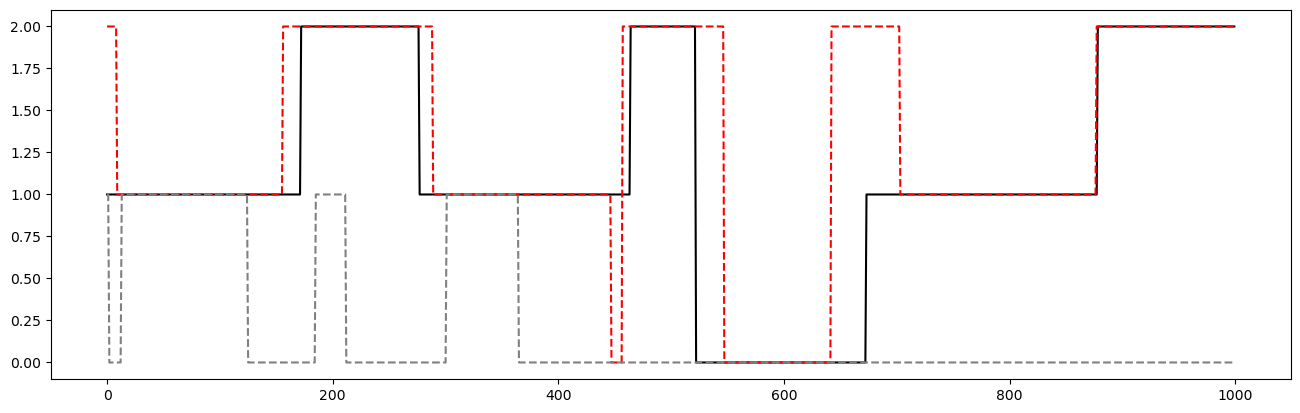

In [180]:
importlib.reload(useful)

val_pred_subset_smoothed = useful.smooth_labels(val_pred_subset)
plt.plot(val_true_subset, c='black')
plt.plot(useful.smooth_labels(val_pred_subset_smoothed), '--', c='red')
plt.plot(useful.smooth_labels(val_pred[:1000]), '--', c='grey')

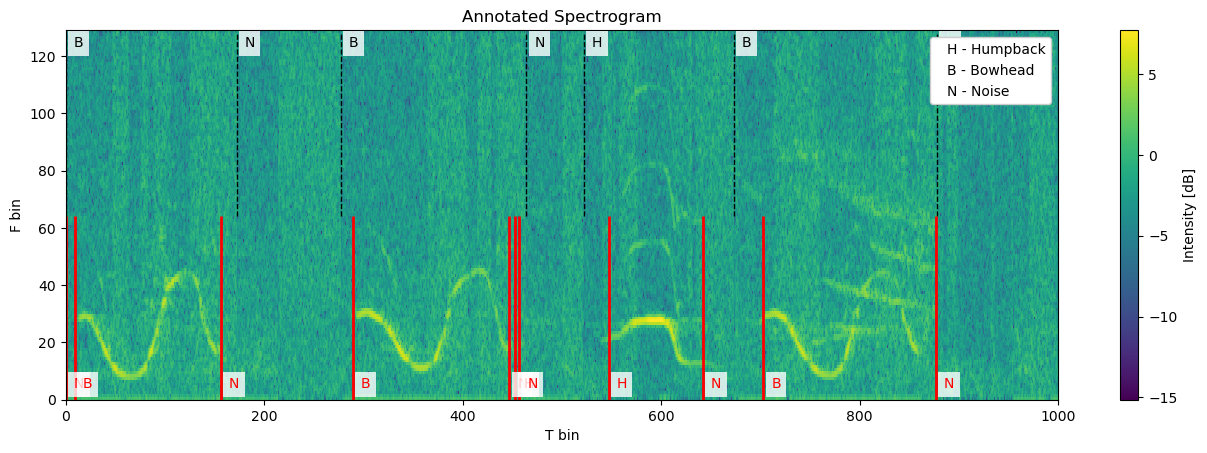

In [181]:
label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(val_features_subset, val_true_subset, val_pred_subset_smoothed, label_to_type, label_to_abr)

# Testing

In [103]:
importlib.reload(useful)
test.features = []
for i in range(len(test.samples)):
    feature = useful.get_log_power_feature(test.samples[i], nfft)
    test.features.append(feature)
test.update_feature_labels()

In [55]:
test_features_concat = np.concatenate(test.features)
_, test_pred, test_log_prob = combined_model.decode_hmmlearn(test_features_concat)

decoding using hmmlearn


In [56]:
test_features_concat_subset = test_features_concat[:1000,:]
test_pred_subset = test_pred[:1000]

In [76]:


smoothed_labels = useful.smooth_labels(test_pred_subset)
# print("Original Labels:", labels)
# print("Smoothed Labels:", smooth_labels(labels))

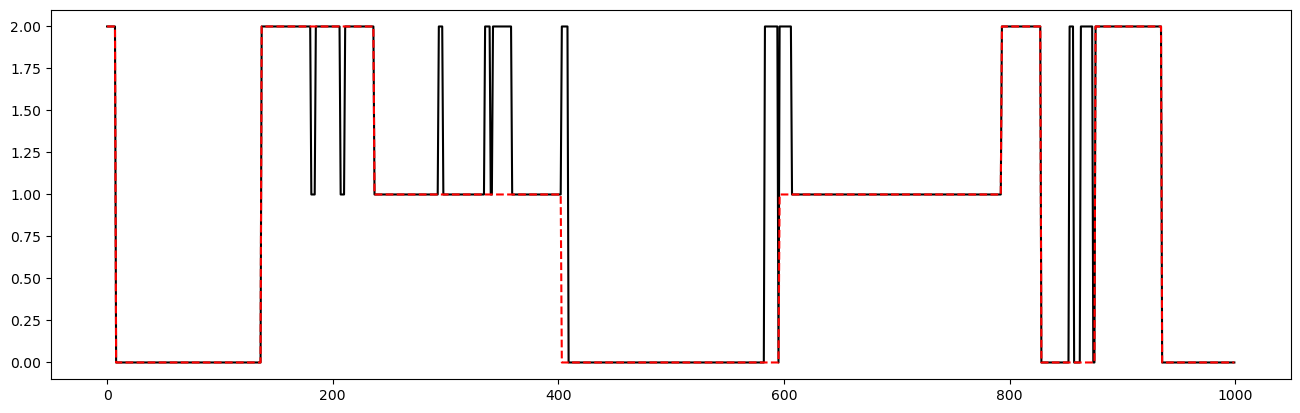

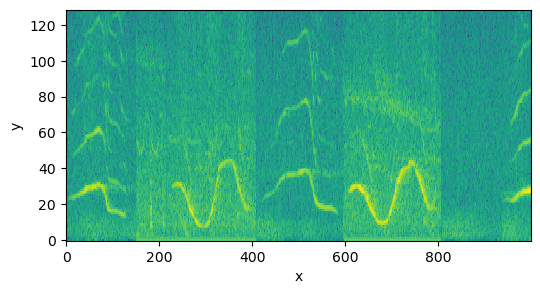

In [77]:
import matplotlib.pyplot as plt
plt.plot(test_pred_subset, c='black')
plt.plot(smoothed_labels, '--', c='red')
useful.vis_helper(test_features_concat_subset)

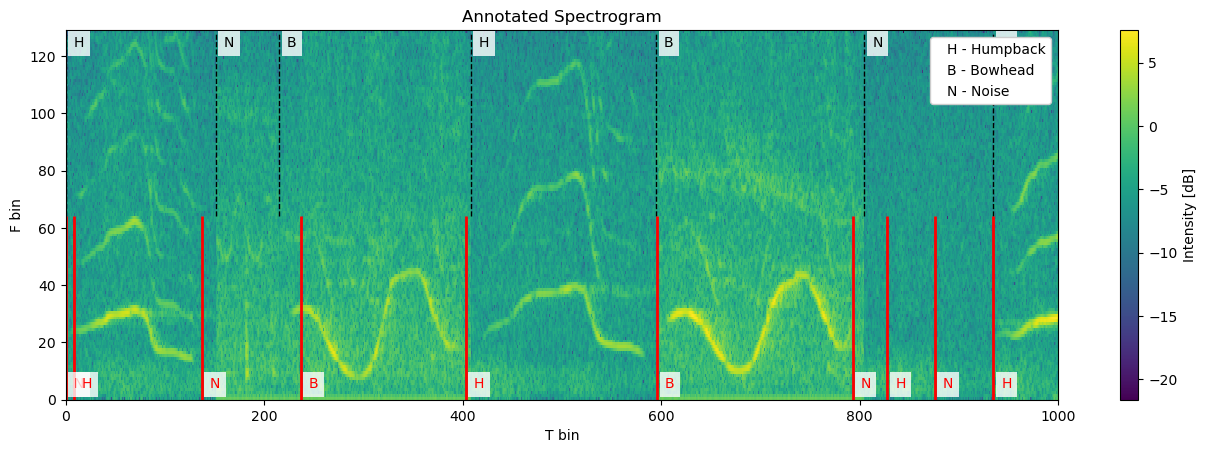

In [135]:
# plot spectrogram showing models and given annots,
importlib.reload(useful)

label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(test_features_concat_subset, np.concatenate(test.feature_labels)[:1000], smoothed_labels, label_to_type, label_to_abr)